In [1]:
import matplotlib.dates as mdates
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator

from src.visualisation.visualize import apply_mpl_settings

apply_mpl_settings()
import datetime
import json
from collections import defaultdict
from pathlib import Path

import numpy as np
import scipy.stats as stats
import pandas as pd

from src.data.analysis import Circle, get_mean_std, get_timestamp
from src.visualisation.visualize import apply_defaults, apply_grid

# Dataset

In [2]:
interim_path = Path('..', '..', 'data', 'interim', 'foils')
raw_path = Path('..', '..', 'data', 'raw', 'foils')

In [16]:
ref_dataset = '2020_10_12_Co60'
#ref_dataset = '2022_11_03_Co60'
ref_dose_Gy = 60.
ref_dataset_path = Path(interim_path, ref_dataset)
list_of_ref_datasets = []
ref_background_dataset = ''
if ref_dataset_path.exists():
    list_of_ref_datasets = sorted((entry.name for entry in ref_dataset_path.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
    ref_background_dataset = sorted((entry.name for entry in ref_dataset_path.iterdir() if entry.is_dir()))[-1]
ref_background_dataset, ' '.join(list_of_ref_datasets)

('bg_30s',
 '2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40')

In [42]:
#dataset = '2022_11_17_bp'
dataset = '2022_11_18_sobp'
#dataset = '2022_11_03_Co60'
dataset_path = Path(interim_path, dataset)
list_of_datasets = []
background_dataset = ''
if dataset_path.exists():
    list_of_datasets = sorted((entry.name for entry in dataset_path.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
    background_dataset = sorted((entry.name for entry in dataset_path.iterdir() if entry.is_dir()))[-1]
background_dataset, ' '.join(list_of_datasets)

('tlo_30s',
 '1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40')

In [43]:
if list_of_datasets:
    [entry.name for entry in Path(dataset_path, list_of_datasets[0]).iterdir()]

In [44]:
df_ref_data = {'det_id' : [], 'signal_mean' : [], 'signal_std' : [], 'bg_signal_mean' : [], 'bg_signal_std' : []}
filename = 'raw-after-ff'

bg_data = np.load(f'{interim_path}/{ref_dataset}/{ref_background_dataset}/raw.npy')

for det in list_of_ref_datasets:
    df_ref_data['det_id'].append(int(det))
    data = np.load(f'{interim_path}/{ref_dataset}/{det}/{filename}.npy')
    analysis_circle = Circle.from_json(f'{interim_path}/{ref_dataset}/{det}/analysis-circle.json')
    mean, std = get_mean_std(data, analysis_circle)
    df_ref_data[f'signal_mean'].append(mean)
    df_ref_data[f'signal_std'].append(std)

    # background
    mean, std = get_mean_std(bg_data, analysis_circle)
    df_ref_data[f'bg_signal_mean'].append(mean)
    df_ref_data[f'bg_signal_std'].append(std)

print("done")
df_ref = pd.DataFrame.from_dict(df_ref_data)
df_ref['dose_Gy_per_signal'] = ref_dose_Gy / df_ref['signal_mean']
df_ref.head()

done


,det_id,signal_mean,signal_std,bg_signal_mean,bg_signal_std,dose_Gy_per_signal
0,2,213.477295,16.016504,1019.775085,8.520552,0.281060
1,3,214.043198,16.172724,1019.906372,8.548158,0.280317
2,4,209.799133,16.619331,1019.875732,8.532111,0.285988
3,5,222.695465,19.313269,1019.933838,8.569408,0.269426
4,6,220.134644,17.293427,1019.914612,8.581979,0.272560


In [47]:
df_data = defaultdict(list)
df_data['det_id'] = []
df_data['timestamp'] = []

bg_data = np.load(f'{interim_path}/{ref_dataset}/{ref_background_dataset}/raw.npy')

for filename in ('raw', 'raw-bg-image-removed', 'raw-aligned', 'raw-after-ff', 'bg'):
    df_data[f'{filename}_signal_mean'] = []
    df_data[f'{filename}_signal_std'] = []
for det in list_of_datasets:
    df_data['det_id'].append(int(det))
    df_data['timestamp'].append(get_timestamp(f'{raw_path}/{dataset}/{det}/Pos0/metadata.txt'))

    analysis_circle = Circle.from_json(f'{interim_path}/{dataset}/{det}/analysis-circle.json')
    aligned_analysis_circle = Circle.from_json(f'{interim_path}/{dataset}/{det}/aligned-analysis-circle.json')

    # background
    mean, std = get_mean_std(bg_data, aligned_analysis_circle)
    df_data[f'bg_signal_mean'].append(mean)
    df_data[f'bg_signal_std'].append(std)

    for filename in ('raw', 'raw-bg-image-removed', 'raw-aligned', 'raw-after-ff'):
        data = np.load(Path(dataset_path, det, f'{filename}.npy'))
        circle = analysis_circle
        if 'aligned' in filename:
            circle = aligned_analysis_circle
        mean, std = get_mean_std(data, circle)
        df_data[f'{filename}_signal_mean'].append(mean)
        df_data[f'{filename}_signal_std'].append(std)
df = pd.DataFrame.from_dict(df_data)
df.tail()

,det_id,timestamp,raw_signal_mean,raw_signal_std,raw-bg-image-removed_signal_mean,raw-bg-image-removed_signal_std,raw-aligned_signal_mean,raw-aligned_signal_std,raw-after-ff_signal_mean,raw-after-ff_signal_std,bg_signal_mean,bg_signal_std
35,36,2022-11-18 13:35:51+01:00,1281.425659,18.898048,222.891434,24.293392,216.128540,18.185917,216.061554,23.064438,1019.526855,8.523955
36,37,2022-11-18 13:37:22+01:00,1277.482666,18.931679,218.966965,25.971323,212.766724,21.630875,212.694153,25.912294,1019.526855,8.523955
37,38,2022-11-18 13:38:50+01:00,1286.281494,21.065201,227.765747,25.080381,220.852310,17.369370,220.802673,23.714291,1019.526855,8.523955
38,39,2022-11-18 13:40:31+01:00,1289.591553,22.145433,231.075241,27.459835,224.135788,20.955683,224.038040,26.409412,1019.526855,8.523955
39,40,2022-11-18 13:42:01+01:00,1286.958618,19.297680,228.151840,23.707457,221.190659,17.200302,221.168610,22.304155,1019.526855,8.523955


# Figure 1 - raw signal

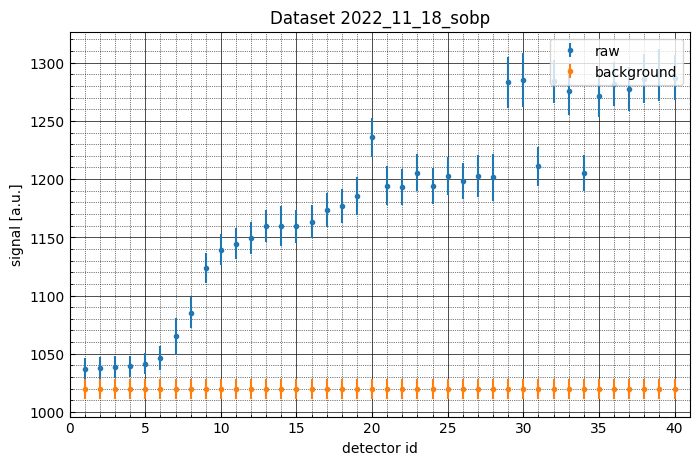

In [46]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Dataset {dataset}')
ax.errorbar(df.det_id, df['raw_signal_mean'], yerr=df['raw_signal_std'], fmt='', linestyle='', marker='.', label='raw')
ax.errorbar(df.det_id, df['bg_signal_mean'], yerr=df['bg_signal_std'], fmt='', linestyle='', marker='.', label='background')
apply_grid(ax)
ax.legend(loc='upper right')
if list_of_datasets:
    ax.set_xlim(int(min(list_of_datasets, key=lambda s:int(s)))-1, int(max(list_of_datasets, key=lambda s:int(s)))+1);
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('detector id')
ax.set_ylabel('signal [a.u.]');

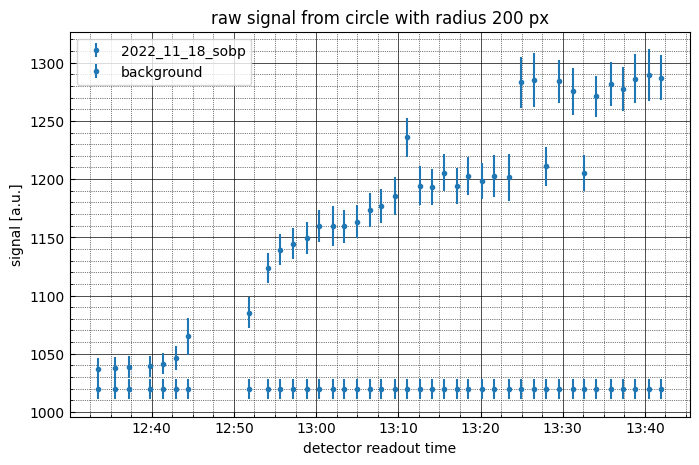

In [30]:
fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(df.timestamp, df['raw_signal_mean'], yerr=df['raw_signal_std'], fmt='', linestyle='', marker='.', label=dataset, color="C0")
ax.errorbar(df.timestamp, df['bg_signal_mean'], yerr=df['bg_signal_std'], fmt='', linestyle='', marker='.', label='background')
apply_grid(ax)
ax.legend(loc='upper left')
ax.set_xlabel('detector readout time')
ax.set_ylabel('signal [a.u.]');
ax.set_title(f'raw signal from circle with radius {analysis_circle.r} px')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=datetime.timezone(datetime.timedelta(hours=1))))

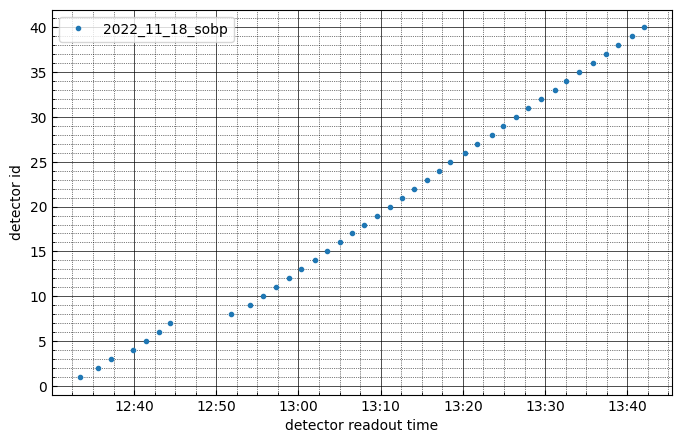

In [44]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df.timestamp, df.det_id, linestyle='', marker='.', label=dataset, color="C0")
apply_grid(ax)
ax.legend(loc='upper left')
ax.set_xlabel('detector readout time')
ax.set_ylabel('detector id')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=datetime.timezone(datetime.timedelta(hours=1))));

# Figure 2 - processing

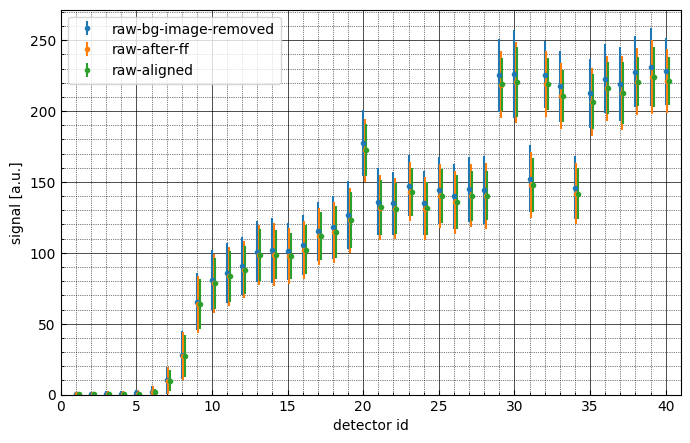

In [45]:
fig, ax = plt.subplots(figsize=(8,5))
for id, filename in enumerate(('raw-bg-image-removed', 'raw-after-ff', 'raw-aligned')):
    ax.errorbar(df.det_id+id/10, df[f'{filename}_signal_mean'], yerr=df[f'{filename}_signal_std'], fmt='', linestyle='', marker='.', label=filename)
apply_defaults(ax)
ax.legend()
if list_of_datasets:
    ax.set_xlim(int(min(list_of_datasets, key=lambda s:int(s)))-1, int(max(list_of_datasets, key=lambda s:int(s)))+1);
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('detector id')
ax.set_ylabel('signal [a.u.]');

# Figure 3 - doses

In [46]:
df['dose_Gy_uncorrected_mean'] = np.nan
df['dose_Gy_uncorrected_std'] = np.nan
for det in list_of_datasets:
    det_id = int(det)
    if det_id in df_ref.det_id.values:
        df.loc[df.det_id==det_id, 'dose_Gy_uncorrected_mean'] = df_ref.loc[df_ref.det_id==det_id, 'dose_Gy_per_signal'].values * df.loc[df.det_id==det_id, 'raw-after-ff_signal_mean'].values
        df.loc[df.det_id==det_id, 'dose_Gy_uncorrected_std'] = df_ref.loc[df_ref.det_id==det_id, 'dose_Gy_per_signal'].values * df.loc[df.det_id==det_id, 'raw-after-ff_signal_std'].values

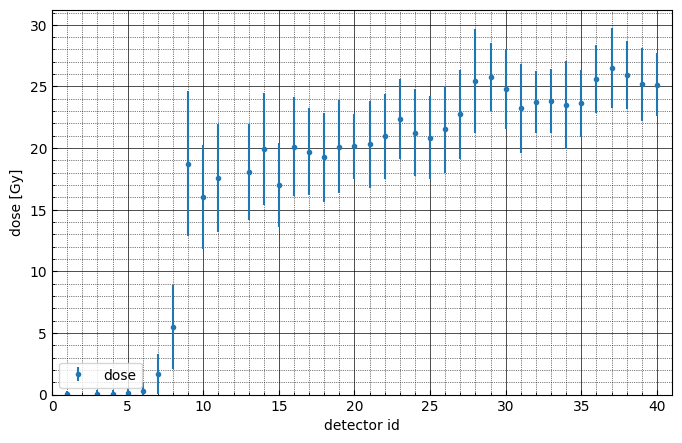

In [47]:
fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(df.det_id, df['dose_Gy_uncorrected_mean'], yerr=df['dose_Gy_uncorrected_std'], fmt='', linestyle='', marker='.', label='dose')
apply_defaults(ax)
ax.legend(loc=3)
if list_of_datasets:
    ax.set_xlim(int(min(list_of_datasets, key=lambda s:int(s)))-1, int(max(list_of_datasets, key=lambda s:int(s)))+1);
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('detector id')
ax.set_ylabel('dose [Gy]');

# Figure 4 - 2D images

In [48]:
det = 4

In [49]:
try:
    vmax_data = max(np.nanpercentile(a=np.load(Path(dataset_path, f'{det}', f'{filename}.npy')), q=95) for filename in ('raw-bg-image-removed', 'raw-after-ff', 'raw-aligned'))
    print(f'vmax_data = {vmax_data}')

    vmax_ref_data = max(np.nanpercentile(a=np.load(f'{interim_path}/{ref_dataset}/{det}/{filename}.npy'), q=95) for filename in ('raw-bg-image-removed', 'raw-after-ff', 'raw-aligned'))
    print(f'vmax_ref_data = {vmax_ref_data}')

    detector_circle = Circle.from_json(f'{interim_path}/{dataset}/{det}lv/det-circle.json')
    aligned_det_circle = Circle.from_json(f'{interim_path}/{dataset}/{det}lv/aligned-det-circle.json')

    analysis_circle = Circle.from_json(f'{interim_path}/{dataset}/{det}/analysis-circle.json')
    aligned_analysis_circle = Circle.from_json(f'{interim_path}/{dataset}/{det}/aligned-analysis-circle.json')
except FileNotFoundError:
    print(f'no data for detector {det}')

vmax_data = 31.869421005249023
vmax_ref_data = 348.589111328125


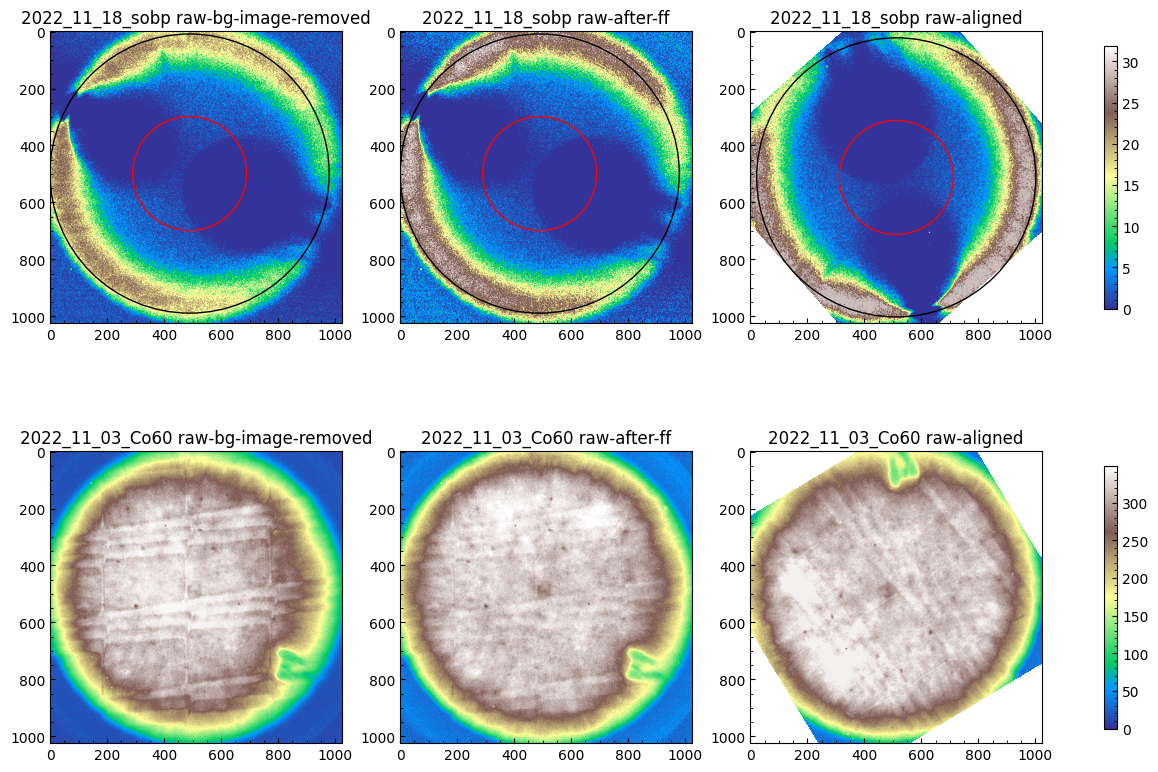

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,10))

for col_id, filename in enumerate(('raw-bg-image-removed', 'raw-after-ff', 'raw-aligned')):
    try:
        data = np.load(Path(dataset_path, f'{det}', f'{filename}.npy'))
    except FileNotFoundError:
        print(f'no data for detector {det}')
        continue
    data_for_plotting = np.clip(data, a_min=None, a_max=np.nanpercentile(a=data, q=95))
    data_plot = axes[0][col_id].imshow(data_for_plotting, cmap='terrain', vmin=0, vmax=vmax_data);
    axes[0][col_id].set_title(f'{dataset} {filename}')

    ref_data = np.load(f'{interim_path}/{ref_dataset}/{det}/{filename}.npy')
    ref_data_for_plotting = np.clip(ref_data, a_min=None, a_max=np.nanpercentile(a=ref_data, q=95))
    ref_data_plot = axes[1][col_id].imshow(ref_data_for_plotting, cmap='terrain', vmin=0, vmax=vmax_ref_data);
    axes[1][col_id].set_title(f'{ref_dataset} {filename}')

    ax = axes[0][col_id] 
    if 'aligned' in filename:
        ax.add_artist(plt.Circle(xy=(aligned_det_circle.x, aligned_det_circle.y), radius=aligned_det_circle.r, color='black', fill=False, transform=ax.transData))
        ax.add_artist(plt.Circle(xy=(aligned_analysis_circle.x, aligned_analysis_circle.y), radius=aligned_analysis_circle.r, color='red', fill=False, transform=ax.transData))
    else:
        ax.add_artist(plt.Circle(xy=(detector_circle.x, detector_circle.y), radius=detector_circle.r, color='black', fill=False, transform=ax.transData))
        ax.add_artist(plt.Circle(xy=(analysis_circle.x, analysis_circle.y), radius=analysis_circle.r, color='red', fill=False, transform=ax.transData))

fig.colorbar(data_plot, ax=axes[0], location='right', shrink=0.75)
fig.colorbar(ref_data_plot, ax=axes[1], location='right', shrink=0.75);

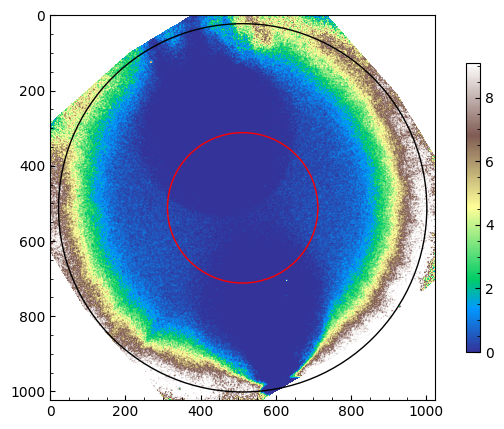

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
try:
    data = np.load(Path(dataset_path, f'{det}', f'raw-aligned.npy'))
    ref_data = np.load(f'{interim_path}/{ref_dataset}/{det}/raw-aligned.npy')
except  FileNotFoundError:
    print(f'no data for detector {det}')
    pass
data_Gy_uncorrected = data * ref_dose_Gy / ref_data
data_for_plotting = np.clip(data_Gy_uncorrected, a_min=None, a_max=np.nanpercentile(a=data_Gy_uncorrected, q=95))
data_plot = ax.imshow(data_for_plotting, cmap='terrain', vmin=0);
ax.add_artist(plt.Circle(xy=(aligned_det_circle.x, aligned_det_circle.y), radius=aligned_det_circle.r, color='black', fill=False, transform=ax.transData))
ax.add_artist(plt.Circle(xy=(aligned_analysis_circle.x, aligned_analysis_circle.y), radius=aligned_analysis_circle.r, color='red', fill=False, transform=ax.transData))
fig.colorbar(data_plot, ax=ax, location='right', shrink=0.75);